
<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">EM Connectomics</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Wednesday, August 25, 2021</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>In this session, we introduce how to query the anotation database and give a flavor of how to use the results to do some simple analysis. By the end, you should be able to query for neurons, query for synapses between those neurons, and visualize the neurons and synapes.

</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Background</h2>

<p>
This dataset is part of a collaboration between the Tolias lab at Baylor,
the Allen Institute, and Sebastian Seung's lab at Princeton University,
as part of the IARPA Microns project.  
</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Local setup instructions</h2>

<p>
Because this dataset is part of a collaboration, it has not been packaged 
through the usual AllenSDK mechanism.  Working with Princeton we have developed two packages for querying and visualizing the data.  If you want to setup your local computer's python system to use these packages you'll need to install them and their dependancies. 
</p>

<p>
The easiest way to install is to use Anaconda python.  Open up a terminal, or a command prompt on windows.  Navigate to the directory where you have checked out the swdb_2021 repository. Activate a conda environment if you'd like then type..

</div>
<h4>Linux/OSX</h4>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
./scripts/em_conda_install.sh
</div>
<h4>Windows</h4>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">
./scripts/em_conda_install.bat
</div>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
You'll need to restart your kernel after you do the install
</div>




<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Drive Path</h2>
First we need to know where the data is on your system.  If you are running on Linux or Windows, edit this cell to reflect where the data is.  If on AWS or mac the location here is likely correct.

We also need to decide what kind of visualization platform you'd like to run.  Locally, we'd reccomend using vtk, on AWS that isn't an option so we are suggesting you use itkwidgets.  vtkplotter is another option that we are demonstrating here.  We've autoselected it based upon the platform but you can override those choices if you'd like to.

</div>

<h2>3D Visualization Methods </h2>

EM data involves high resolution reconstructions of neurons, and so visualizing them interatively in 3D is essential to understanding the data (plus it's just fun).  This requires use of more specialized plotting packages than matplotlib.  There are a few options that have different plusses and minuses that are summarized below.  We'll show you code snippets from all methods, but execute the one based upon the viz_method variable defined in the next cell.
<table>
    <tr>
        <td><h3>viz_method</h3></td>
        <td><h3>pros</h3></td>
        <td><h3>cons</h3></td>
    </tr>
    <tr>
        <td>
           vtk
        </td>
        <td>Fastest <br/>
            Most features: <br/>
            mesh coloring<br/>  
            programatic camera control<br/>
            programatic saving<br/>
            extensible</td>
        <td> Requires local installation <br/>(no AWS possible)</td>
    </tr>
    <tr>
        <td> itkwidgets</td>
        <td> fastest notebook widget <br/>
             easy screen shot <br/>
             bug free <br/>
             aws compatible <br/>
        </td>
        <td>
        no programatic camera control<br/>
        no advanced mesh coloring
        </td> 
    </tr>    
    </table>

In [25]:
import platform
import os

platstring = platform.platform()
if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2021/em_connectomics"
    viz_method= 'vtk'
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em_connectomics"
    viz_method= 'vtk'
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/swdb2021-em"
    viz_method='itkwidgets'
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2021/em_connectomics"
    
# OR if you'd like to override the auto options
# data_root = "."
# viz_method = one of ['itkwidgets', 'vtk']
# viz_method = 'vtk'
mesh_folder = os.path.join(data_root, 'meshes')
skeleton_folder = os.path.join(data_root, 'proofread_skeletons')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import the key modules</h2>
Our analysis workflows use a couple of special purpose packages we have developed. Here, we are going to look at the CAVEclient (Connectome Annotation Versioning Engine), our package that quickly performs simple analysis queries and produces tidy Pandas dataframes.
</div>

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Import some of our favorite modules</h2>
Our analysis workflows makes use of many of the common scientific computing packages like Numpy and Pandas.
</div>

In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Setting up a CAVE account </h2>

CAVE is the Connectome Annotation Versioning Engine.
It is a collection of services which manage proofreading and data annotation for large scale connectomics dataset.
These services were developed during the IARPA MICrONS program, but now support data from several projects including FlyWire.  You need to have an account on CAVE to use its services.

To get an account please first go to this [website](https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public_v117)

You should be prompted to login with a google account and then you must seperately accept the terms and conditions.

Once you have registered, you can then follow along this notebook.
This notebook will show you how to get a programatic token that you can use to authenticate to the services in order to make queries. The token can then be used on different computers.

<h2>Setting key parameters </h2>
Every combination of image and segmentation data we call a 'datastack', since a dataset might have multiple such 'datastacks' associated with it.  The cortical mm^3 datastack that we are going to use is called `minnie65_public_v117` named because it is approximately 65% of the whole volume, and its the public releasse that corresponds to the 117th iteration of proofreading results we aggregated.
</div>


In [4]:
client = CAVEclient()

if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

In [5]:
# if you have not yet setup this computer, uncomment this below line
# paste the token from the website in, and run the line

# client.auth.save_token(token="paste_token_here", overwrite=True)

# then comment or delete the line as you don't need to run it on this computer  again

In [6]:
datastack_name = 'minnie65_public_v117'

client = CAVEclient(datastack_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Terms of Service Error</h2>
If for some reason you are getting an error that says you haven't signed the terms of service, visit this link.

<a href="https://global.daf-apis.com/sticky_auth/api/v1/tos/2/accept"> Microns Public TOS </a>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Client Basics</h2>
The client lets you connect to a number of different services, and you can read about all of them in  <a href="https://caveclient.readthedocs.io/">the CAVEclient documentation</a>

For this notebook however we will focus on the 'materialize' client which lets you access tables of annotations on the data, including cells, nuclei and synapses. 

To see what tables are available, use the 'get_tables' method.
</div>

In [7]:
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

In [8]:
# For each table you can get metadata about that table
client.materialize.get_table_metadata('nucleus_detection_v0')

{'table_name': 'nucleus_detection_v0',
 'aligned_volume': 'minnie65_phase3',
 'valid': True,
 'id': 6,
 'created': '2020-09-28T22:39:06.523707',
 'schema': 'nucleus_detection',
 'user_id': '121',
 'reference_table': '',
 'schema_type': 'nucleus_detection',
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'flat_segmentation_source': 'precomputed://s3://bossdb-open-data/microns/minnie/minnie65-phase3-ws/nuclei/v0/seg',
 'voxel_resolution': [4.0, 4.0, 40.0]}

In [9]:
# and how many annotations are in it
# the maybe most important table is the synapse table (synapses_pni_2)
# which has >330 million synapses, so querying its length takes a long time
client.materialize.get_annotation_count('nucleus_detection_v0')


144120

In [10]:
# lets look at the proofreading status table
# if you ask for the whole thing, the client will give you the first 200K rows
# which is good enough to cover everything other than synapses
prf_df= client.materialize.query_table('proofreading_status_public_release')
prf_df.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,1,t,89529934389098311,864691136296964635,864691136296964635,extended,non,"[179808, 216672, 23361]"
1,2,t,90584228533843146,864691136311986237,864691136311986237,extended,non,"[187840, 207232, 22680]"
2,3,t,89528353773943370,864691135355207119,864691135355207119,extended,non,"[180016, 204592, 22798]"
3,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[191424, 209888, 22845]"
4,5,t,88897234233461709,864691136422983727,864691136422983727,extended,non,"[175248, 220944, 23561]"


In [11]:
# so what do those columns mean?
# you can check the metadata!
client.materialize.get_table_metadata('proofreading_status_public_release')['description']

"The proofreading status of neurons that have been comprehensively proofread as of Materialization v117. Axon and dendrite compartment status are marked separately under 'axon_status' and 'dendrite_status', as proofreading effort was applied differently to the different compartments in some cells. There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. The 'pt_position' is at a cell body or similar core position for the cell. The column 'valid_id' provides the root id when the proofreading was last checked. If the current root id in 'pt_root_id' is not the same as 'valid_id', there is no guarentee that the proofreading status is correct. Very small false axon merges (axon fragments approximately 5 microns or less

<h3> Proofreading Status Descriptions</h3>
<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>valid</td>
        <td>A bookkeeping column, should always be 't'</td>
    </tr>
    <tr>
        <td>pt_position</td>
        <td>This is the x,y,z location in voxels of the point that was annotated here as being at this cells soma location. Note, the dataset has a voxel resolution of 4,4,40 nm, and so often you want to convert this column to a nm position, which we will do below.  </td>
    </tr>
    <tr>
        <td>pt_supervoxel_id</td>
        <td>You can generally ignore this column, we keep it for bookkeeping in order to make it easier to update this annotation when the segmentation changes.  </td>
    </tr>
    <tr>
        <td>pt_root_id</td>
        <td>This is the unique ID of the 'root' object in the segmentation, sometimes we refer to this as a segmentation id or a cell id.</td>
    </tr>
    <tr>
        <td>valid_id</td>
        <td>This is the ID of the object when this proofreading status was applied, for this release, this column matches the pt_root_id and so can be ignored.  Its here to help alert us if the object changed since the human who judged this neuron to be 'clean' for example.  In such case its possible theoretically that the cell is no longer 'clean'. </td>
    </tr>
    <tr>
        <td>status_dendrite</td>
        <td>There are three possible status values for each compartment: 'non' indicates no comprehensive proofreading. 'clean' indicates that all false merges have been removed, but all tips have not necessarily been followed. 'extended' indicates that the cell is both clean and all tips have been followed as far as a proofreader was able to. </td>
    </tr> 
    <tr>
        <td>status_axon</td>
        <td>same as status_dendrite but for axon </td>
    </tr> 
    <tr>
        <td>pt_position</td>
        <td>A location at a cell body or similar core position for the cell. (units from metadata are [4,4,40] nm voxels) </td>
    </tr> 
    
</table>



In [12]:
# with the client we can do simply filters based upon
#  the column name and values you want to include or exclude
# with filter_in_dict, filter_out_dict, filter_equal_dict

# let get all the cells with extended axons
ext_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_equal_dict={'status_axon':'extended'})

# lets get all the cells with any dendritic proofreading (clean or extended)
clean_dend_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_out_dict={'status_dendrite':['non']})

# how many in each
ext_axon_df.shape, clean_dend_df.shape

((78, 8), (601, 8))

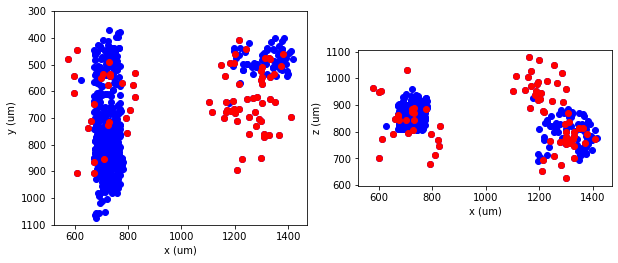

In [13]:
# useful function for converting a pandas data frame voxel position
# column to a np.array of Nx3 size in nm
def convert_to_nm(col, voxel_size=[4,4,40]):
    return np.vstack(col.values)*voxel_size

# function to plot a dataframe
def plot_soma_loc(df, ax, x=0, y=1, c='r'):
    
    # convert the position to microns
    pos = convert_to_nm(df['pt_position'])/1000
    
    # plot two dimensions as a scatterplot
    ax.scatter(pos[:,x], pos[:,y], c=c)

# make a new axis with two subplots
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharex=ax1)

# plot each dataframe in a different color
plot_soma_loc(clean_dend_df, ax1, c='b')
plot_soma_loc(ext_axon_df, ax1, c='r')


# label some axis, make x,y scaling same
ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
# to keep the pia 'up'
ax1.set_ylim(1100,300)
ax1.set_aspect('equal')

# plot the same thing as x,z
plot_soma_loc(clean_dend_df, ax2, x=0, y=2, c='b')
plot_soma_loc(ext_axon_df, ax2, x=0, y=2, c='r')

ax2.set_xlabel('x (um)')
ax2.set_ylabel('z (um)')
ax2.set_aspect('equal')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Coordinate System</h2>
Below is a diagram to help you visualize the coordinate system plotted above.  
</div>


<img src="../resources/EM_coordinate_system.png"> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Querying for synapses</h2>
Let's pick out a cell ID of an excitatory neuron and then find all the synapses onto that neuron</div>


In [14]:
neuron_id  = clean_dend_df.iloc[0].pt_root_id
neuron_id

864691136296964635

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we are ready to query synapses for this neuron. Because the analysis database can, in principle, handle multiple different sources of synapses, we have to specify which synapse table we want to use. The current table holding the most up to date automated synapse detection is called `synapses_pni_2`.  The "info" service has this information however, so we don't need to remember it.

Because synapses are such a common query, we have written a wrapper method `synapse_query` which makes uses the default synapse table and simplifies the syntax. So, we can specify which synapses we get back from the table by setting the `post_ids` argument to a list of IDs, which makes a query that only returns synapses whose postsynaptic id is the one selected.  You can also filter by `pre_ids` which will do the same for the pre-synaptic side. Setting this will only return synapses that are from certain neurons.  Setting both `pre_ids` and `post_ids` will return only synapses that are from the `pre_ids` onto the `post_ids`.
</div>

In [15]:
print(client.materialize.synapse_table)
post_synapse_df = client.materialize.synapse_query(post_ids = neuron_id)
# lets post the shape to see how many synapses we have
print(post_synapse_df.shape)
# and take a peak at the whole dataframe
post_synapse_df.head()

synapses_pni_2
(969, 10)


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position
0,183011812,t,90863916938376134,864691135068971402,90863916938361516,864691136296964635,6504,"[189780, 193912, 23701]","[189858, 193858, 23690]","[189826, 193838, 23694]"
1,141016922,t,87629977826679356,864691135497209028,87629977826685441,864691136296964635,2228,"[166290, 216594, 19926]","[166274, 216634, 19931]","[166282, 216658, 19928]"
2,160119812,t,88962174004906022,864691135839729023,88962174004911650,864691136296964635,1604,"[176060, 180734, 22613]","[176042, 180744, 22617]","[176036, 180704, 22615]"
3,216034962,t,93614895299788337,864691136091095220,93614895299785079,864691136296964635,8008,"[209904, 243226, 26039]","[209820, 243262, 26035]","[209892, 243300, 26036]"
4,169430591,t,89950015946103600,864691136755828334,89950015946101534,864691136296964635,3696,"[183038, 200726, 18507]","[183068, 200674, 18514]","[183054, 200652, 18510]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Synapse Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to this synapse annotation</td>
    </tr>
    <tr>
        <td>pre_pt_supervoxel_id</td>
        <td>a bookkeeping column for the presynaptic side </td>
    </tr>
    <tr>
        <td>pre_pt_root_id</td>
        <td>the ID of the cell on the presynaptic side</td>
    </tr>
    <tr>
        <td>post_pt_supervoxel_id</td>
        <td>Same bookkeeping column as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>post_pt_root_id</td>
        <td>Same as pre_pt but for the post synaptic side</td>
    </tr>
    <tr>
        <td>size</td>
        <td>The size of the synaptic cleft in units of 4,4,40 voxels.</td>
    </tr>
    <tr>
        <td>pre_pt_position</td>
        <td>a point that is in the pre-synaptic terminal of this synapse (in voxels) </td>
    </tr>
    <tr>
        <td>post_pt_position</td>
        <td>Same as pre_pt but for the post synaptic side.</td>
    </tr>
    <tr>
        <td>ctr_pt_position</td>
        <td>a point that is on the center of the synapse (in voxels)</td>
    </tr>
</table>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in this table is a single synapse. You should see that the value in the post_pt_root_id column is the same for all, and equals the id you selected above. 
<h5>Note again that position columns are in voxel coordinates, just like Neuroglancer displays in the upper left corner. A single voxel has dimensions 4x4x40 nm.</h5>
</div>

Text(0, 0.5, 'z (um)')

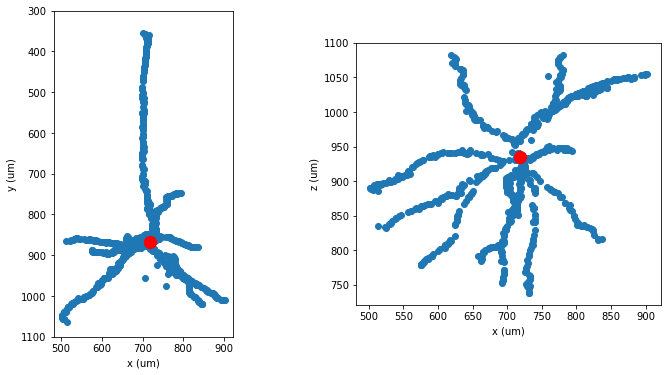

In [16]:
# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = convert_to_nm(post_synapse_df.ctr_pt_position)
# and plot their positions in x,y along with the soma position as a red circle
f ,ax =plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,1]/1000)

# add the soma position as a red circle
soma_pos = convert_to_nm(clean_dend_df.pt_position)
ax[0].scatter([soma_pos[0,0]/1000],[soma_pos[0,1]/1000],c='r',s=150)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x (um)')
ax[0].set_ylabel('y (um)')
ax[0].set_ylim(1100,300)

ax[1].scatter(syn_pos_nm[:,0]/1000, syn_pos_nm[:,2]/1000)

# add the soma position as a red circle
soma_pos = convert_to_nm(clean_dend_df.pt_position)
ax[1].scatter([soma_pos[0,0]/1000],[soma_pos[0,2]/1000],c='r',s=150)
ax[1].set_aspect('equal')
ax[1].set_xlabel('x (um)')
ax[1].set_ylabel('z (um)')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now lets figure out which excitatory neuron makes the most synapses onto this neuron
</div>

In [17]:
# pandas groupby to count number of synapses from different neurons
# followed by transform to label the individual synapses with 
# how many other synapses are in that connection.

# transform labels all the rows in the group with the result of this function on the group
syn_in_conn=post_synapse_df.groupby('pre_pt_root_id').transform(len)['id']
# save this result in a new colum
post_synapse_df['syn_in_conn']=syn_in_conn
post_synapse_df[['id', 'pre_pt_root_id', 'size','syn_in_conn']].sort_values('syn_in_conn', ascending=False).head()

,id,pre_pt_root_id,size,syn_in_conn
367,154533592,864691135837393555,6780,8
114,162219403,864691135837393555,7600,8
322,162782088,864691135837393555,10100,8
838,162782172,864691135837393555,7784,8
33,159005518,864691135837393555,4668,8


In [18]:

# are any of these synapses from our list of extended axons?
is_from_exc = post_synapse_df.pre_pt_root_id.isin(ext_axon_df.pt_root_id.values)
e_to_neuron_df=post_synapse_df[is_from_exc]
e_to_neuron_df[['id',
                'post_pt_root_id',
                'pre_pt_root_id',
                'syn_in_conn',
                'ctr_pt_position',
                'size']]

,id,post_pt_root_id,pre_pt_root_id,syn_in_conn,ctr_pt_position,size
182,176634013,864691136296964635,864691135564752471,1,"[184456, 213532, 21495]",13924


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets get the ID of the neuron that has the largest number of synapses onto this neuron
</div>

In [19]:
# find the neuron with the most synapses
max_input_idx = e_to_neuron_df.syn_in_conn.idxmax()
max_input_neuron = e_to_neuron_df.loc[max_input_idx].pre_pt_root_id
print(max_input_neuron)

# print out the synapses (should be 1)
e_to_neuron_df[e_to_neuron_df.pre_pt_root_id == max_input_neuron]

864691135564752471


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,syn_in_conn
182,176634013,t,90162840501533168,864691135564752471,90162840501531437,864691136296964635,13924,"[184390, 213548, 21500]","[184524, 213568, 21494]","[184456, 213532, 21495]",1


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Linking synapses to somas</h2>
You might want to link synapses to the cell bodies or cell classes of the pre or post-synaptic cells.  To do this, you want to 'merge' (See <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html"> pandas merge docs </a> ) the information between a synapse table and a table of somas. </div>


In [20]:
# lets pull out the table that lists all the soma positions of neurons in the volume
neuron_soma_df = client.materialize.query_table('nucleus_neuron_svm', 
                                                filter_equal_dict={'cell_type':'neuron'})
neuron_soma_df.head()


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,485509,t,is_neuron,neuron,103588564537113366,864691136740606812,"[282608, 103808, 20318]"
1,113721,t,is_neuron,neuron,79951332685465031,864691135366988025,"[110208, 153664, 23546]"
2,263203,t,is_neuron,neuron,87694643458256575,864691135181741826,"[166512, 174176, 24523]"
3,456177,t,is_neuron,neuron,102677963354799688,864691135337690598,"[275616, 135120, 24873]"
4,364447,t,is_neuron,neuron,94449079618306553,864691136883828334,"[216064, 166800, 15025]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Cell Type Local Table Descriptions</h3>
Here's a breakdown of what each of those columns mean.
</div>

<table style={float:left}>
    <tr>
        <td><h4>column</h4></td>
        <td><h4>description</h4></td>
    </tr> 
    <tr>
        <td>id</td>
        <td>The ID that is specific to this nucleus segmentation</td>
    </tr>
        <tr>
        <td>classification_system</td>
        <td>is_neuron indicates that cell_type will be one of neuron, notneuron</td>
    </tr>
    <tr>
        <td>cell_type</td>
        <td>if 'neuron', its predicted to be a neuron, 'not-neuron' it is not a neuron </td>
    </tr>
    <tr>
        <td>pt_supervoxel_id</td>
        <td>a bookkeeping column for the annotation </td>
    </tr>
    <tr>
        <td>pt_root_id</td>
        <td>the ID of the segmentation at the soma 'pt_position'</td>
    </tr>
        <td>pt_position</td>
        <td>a point that is at the centroid of the nucleus segmentation (in voxels)  </td>
    
</table>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in this table is a single nucleus segmentation. We have filtered it to only include the neurons

In [21]:
# merging in the neuron table using 'left' ensures that every row
# in the first dataframe passed (the synapse table) 
# has at least one entry in the result
# more than 1 if there is more than one on the 'right'
# (the second table passed)
e_to_neuron_soma_df = pd.merge(e_to_neuron_df, neuron_soma_df,
         left_on='post_pt_root_id',
         right_on='pt_root_id',
         how='left',
         suffixes=['_syn', '_soma'])

# now pt_position is the soma position
# id_syn is the ID of the synapse
# id_soma is the ID of the soma that had the matched root_id
# pt_position is the position of that soma
e_to_neuron_soma_df[['id_syn',
                     'pre_pt_root_id',
                     'post_pt_root_id',
                     'ctr_pt_position',
                     'id_soma',
                     'pt_position',
                     'cell_type']]

,id_syn,pre_pt_root_id,post_pt_root_id,ctr_pt_position,id_soma,pt_position,cell_type
0,176634013,864691135564752471,864691136296964635,"[184456, 213532, 21495]",269733,"[179808, 216672, 23361]",neuron


In [22]:
# let's pick a different cell_type table
# the E/I call table
ei_df = client.materialize.query_table('allen_soma_ei_class_model_v1')
e_to_neuron_ei_df=pd.merge(e_to_neuron_df, ei_df,
         left_on='post_pt_root_id',
         right_on='pt_root_id',
         how='left',
         suffixes=['_syn', '_soma'])
# now our cell type column predicts whether this 
# synapse post_synaptic side is excitatory or inhibitory
e_to_neuron_ei_df[['id_syn',
                     'pre_pt_root_id',
                     'post_pt_root_id',
                     'ctr_pt_position',
                     'id_soma',
                     'pt_position',
                     'cell_type']]

,id_syn,pre_pt_root_id,post_pt_root_id,ctr_pt_position,id_soma,pt_position,cell_type
0,176634013,864691135564752471,864691136296964635,"[184456, 213532, 21495]",269733,"[179808, 216672, 23361]",excitatory


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Mesh visualization</h3>
Now we can plot these synapses in 2d, but we have the detailed 3d morphology of these neurons, so why don't we look at them!
 </div>

In [23]:
# this is an EM specific package for getting meshes
# and doing analysis on those meshes
from meshparty import trimesh_io, trimesh_vtk
from meshparty import skeletonize, skeleton_io, skeleton

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
To access the 3d meshes of neurons, we need use a MeshMeta object, you have access to a folder with the meshes of all the neurons with cell bodies in the dataset. (i.e. anything with an pt_root_id in the soma_valence_v2 table)
</div>

In [26]:
mm = trimesh_io.MeshMeta(cv_path ="precomputed://gs://iarpa_microns/minnie/minnie65/seg",
                         disk_cache_path=mesh_folder,
                         cache_size=0)

In [27]:
# load the meshes
post_mesh = mm.mesh(seg_id = neuron_id, lod=2)
pre_mesh = mm.mesh(seg_id= max_input_neuron, lod=2)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Meshes are triangular meshes, that are composed of vertices (N,3) and faces (N,3) which are indices into the vertex list
    

The Mesh class is based upon trimesh (<a href="https://github.com/mikedh/trimesh"> https://github.com/mikedh/trimesh</a>), with some added features for doing graphs

You can find the source code for mesh party here .. <a href="https://github.com/sdorkenw/MeshParty">https://github.com/sdorkenw/MeshParty </a>
    </div>

In [28]:
post_mesh.vertices.shape, post_mesh.faces.shape

((76450, 3), (154079, 3))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Below we are going to visualize things in 3d.  Different code paths  illustrate different visualization methods
</div>


In [29]:
# Set viewer equals None so vtk option doesn't error
viewer = None
if viz_method == 'itkwidgets':
    #import ITK widgets view function
    from itkwidgets import view
    
    # step 1
    # convert your actors to vtkpolydata objects
    post_poly_data = trimesh_vtk.trimesh_to_vtk(post_mesh.vertices, post_mesh.faces, None)
    pre_poly_data = trimesh_vtk.trimesh_to_vtk(pre_mesh.vertices, pre_mesh.faces, None)

    # step 2
    # then create a viewer with this view function
    # pass in polydata objects, what colors you want
    # see docstring for more options
    prepostviewer=view(geometries=[post_poly_data, pre_poly_data],
                ui_collapsed=True)

    # viewer controls..
    # pinch movements:  to zoom in and out
    # ctrl+wheel: on a mouse to do the same
    # shift+drag: to pan

    display(prepostviewer)
elif viz_method == 'vtk':

    # Step 1
    # Convert meshes to actors, providing color and opacity
    # options, you can provide vertex colors to color mesh vertices
    # however these will only be relevant for vizmethod=vtk
    post_actor = trimesh_vtk.mesh_actor(post_mesh,
                                    opacity=1.0,
                                    color=(1,0,1))
    pre_actor = trimesh_vtk.mesh_actor(pre_mesh,
                                   opacity=1.0,
                                   color=(0,1,0))
    print("A VTK window should have popped up behind you")
    print("WARNING YOU NEED TO CLOSE IT BY PRESSING Q TO MOVE ON")
    # step 2
    # render them interactively with this function
    # passing a list of actors
    # can optionally specify a path to save a static image
    trimesh_vtk.render_actors([pre_actor, post_actor])

    # vtk controls
    # pinch movements:  to zoom in and out
    # ctrl+wheel: on a mouse to do the same
    # shift+drag: to pan
    # mouse over + f: to zoom to where you point and recenter camera there
    # w: wireframe visualization
    # s: surface visualization
    # q: to exit visualization
    


A VTK window should have popped up behind you
WARNING YOU NEED TO CLOSE IT BY PRESSING Q TO MOVE ON
setting up renderer
done setting up
actors added
camera set
render done
finalizing..


In [30]:
# in vtk and vtkplotter there is more camera control
# so this is how you would automatically center the camera
# on the first synapse between these neurons
max_synapses = e_to_neuron_df[e_to_neuron_df.pre_pt_root_id == max_input_neuron]

# get the location of the first synapse (change 0 to 1 or 2 to look at others)
syn_pos =convert_to_nm(max_synapses.iloc[[0]].ctr_pt_position)

# create a camera object pointed at the synapse
camera = trimesh_vtk.oriented_camera(syn_pos, backoff=20)


if viz_method == 'vtk':
    print("A VTK window should have popped up behind you")
    print("WARNING YOU NEED TO CLOSE IT BY PRESSING Q TO MOVE ON")
    # pass the camera to the render_actors function to control camera
    trimesh_vtk.render_actors([post_actor, pre_actor], camera=camera)
if viz_method == 'itkwidgets':
    print("this should have changed the colors and the camera position in the widget above")
    prepostviewer.geometry_colors = np.array([[.8,0,.8], [0,1,0]], dtype=np.float32)
    prepostviewer.camera = camera

A VTK window should have popped up behind you
WARNING YOU NEED TO CLOSE IT BY PRESSING Q TO MOVE ON
setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Visualizing synapses </h3>
Now what if we just want to see the synapse locations without the mesh of the other side
</div>

In [31]:
# synapse sizes tend to distributed widely
# so we are going to color and size them proportional to the log
syn_color = np.log(post_synapse_df['size'].values)
syn_size = 100*np.log(post_synapse_df['size'].values)

# this will produce spheres at each point with sizes in nm
# and color values that are mapped through a colormap
# in VTK only you can pass explicit colors as well
syn_actor = trimesh_vtk.point_cloud_actor(syn_pos_nm, size=syn_size, color=syn_color)

if viz_method == 'vtk':
    print('remember the window pops up behind')
    trimesh_vtk.render_actors([post_actor, syn_actor])
if viz_method == 'itkwidgets':
    syn_pd = syn_actor.GetMapper().GetInput()
    synviewer = view(geometries=[post_poly_data, syn_pd],
                  geometry_colors=['m','g'],
                  ui_collapsed=True)
    display(synviewer)


remember the window pops up behind
setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Working with Skeletons </h3>
    
Just as the 3D mesh of the neuron is a reduced data representation of the imagery, one can further reduce a 3D mesh into a skeleton format which can benefit certain types of analyses by making it faster/ more optimal. The <a href = "https://meshparty.readthedocs.io/en/latest/guide/skeletons.html" >"skeletonize"</a> library within meshparty allows us to generate these skeletons from a mesh. Note that this algorithm generates a skeleton where skeleton points generated are a subset of the mesh points. For a few cells however, we have already generated these and provide this in the data directory.
    
The Meshwork library allows us to easily store these representations and helps us relate them to each other. A Meshwork object is a data structure that is designed to have three main components that are kept in sync with mesh and skeleton indices: 
    
    mesh: a standard meshparty mesh
    skeleton: a standard meshparty skeleton,
    anno : is a class that holds dataframes and adds some extra info to keep track of indexing. 
    
In addition, the meshwork object itself has a number of skeleton-like functions that know when to use mesh data and when to use skeleton data. For the most part of this tutorial, we will focus on using the skeleton object.

</div>

In [35]:
from meshparty import meshwork
nrn = meshwork.load_meshwork(os.path.join(skeleton_folder,'864691135382556378_axon_labeled.h5'))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Attributes of meshworks objects:
    
    nrn.mesh, nrn.skeleton, nrn.anno

    
Let us now try to visualize the skeleton: nrn.skeleton:
</div>

In [36]:
#Let us try to visualize the skeleton:
# Visualize the whole skeleton 
skeleton_actor= trimesh_vtk.skeleton_actor(nrn.skeleton,color=(0.5,0,0.2))
if viz_method=='vtk':
    
    trimesh_vtk.render_actors([skeleton_actor])
elif viz_method=='itkwidgets':
    sk_pd = skeleton_actor.GetMapper().GetInput()
    skviewer = view(geometries=[sk_pd],
                  geometry_colors=['k'],
                  ui_collapsed=True)
    display(skviewer)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Indexing And Selecting Sets of Interesting Points</h3>

Ok, you are probably really fried by now, but here is one important thing to remember about this meshworks object. The meshworks object contains a mesh with lots of vertices and a skeleton which holds a subset of these vertices. Therefore, in python these points have different "indices" in the mesh and skeleton. For example, if the mesh contains 10000 vertices, the indexing of those would run from 0 - 9999. The skeleton, which contains a subset of 100 of these would have indexing from 0-99. How would you figure out which of the mesh vertices these correspond to?
    
Luckily, we have some really nifty functions that help us distinguish those:
    
Let us first look at some attributes in the meshworks objects:
    
</div>

In [37]:
#Branch points
print("Branch points with mesh indices: \n", nrn.branch_points)
print("Branch points with skeleton indices: \n",nrn.branch_points_skel)

# nrn.branch_points returns a list of branch points of the cell as a mesh index.
# What it's actually doing is finding the branch points of the skeleton, 
# then looking up a single mesh vertex that corresponds to that skeleton vertex.

Branch points with mesh indices: 
 [  286   665  1821  2434  2913  3061  3075  3794  3851  4317  4681  4946
  5092  4890  5212  5233  5257  5311  5406  5467  5603  5875  5916  5829
  6042  6077  5976  6182  6142  6372  6617  6635  7014  7063  6856  7344
  7353  7024  7632  7274  7647  7802  7511  7597  7608  7987  7999  7628
  8040  8046  7683  8240  7895  8256  7912  8270  8299  7002  8429  8098
  8865  8852  9028  9053  8937  9101  9076  9248  9308  9396  9407  9623
  9637  9643  9521  9540  9938  9604  9829 10023 10051 10052 10063  9874
 10257 10335 10982 11203 11367 11370 11557 11764 11846 12418 12497 12647
 13106 13161 13711 13995 14150 14740 14860 15035 15656 16287]
Branch points with skeleton indices: 
 [ 206  482 1079 1425 1580 1646 1708 2040 2070 2289 2403 2527 2590 2606
 2658 2674 2688 2710 2752 2781 2846 2991 3019 3045 3063 3079 3133 3138
 3221 3324 3443 3451 3492 3516 3553 3603 3608 3609 3704 3705 3713 3778
 3793 3811 3815 3818 3823 3830 3840 3846 3847 3922 3924 3929 3933 3

In [38]:
#End points
print("End points with mesh indices: \n", nrn.end_points)
print("End points with skeleton indices: \n",nrn.end_points_skel)



End points with mesh indices: 
 [    0    32    57   265   639   709   806   860   865   883   967   983
   991  1217  1286  1313  1327  1364  1523  1656  1926  2032  2050  2116
  2365  2387  2734  2982  3159  3338  3616  3769  3801  3814  3895  4219
  4244  4248  4555  4798  4904  5240  5344  5694  5842  6153  6204  6313
  6449  6767  6920  7028  7142  7445  7768  7813  8161  8705  8767  8795
  8799  8950  9005  9262  9699  9721  9876 11165 11204 11205 11282 11381
 11393 12093 12474 12768 12827 12967 13116 13131 13283 13376 13394 13409
 13618 13635 13647 13681 13941 14245 14250 14495 14534 14569 14738 14810
 14917 15021 15164 15211 15232 15374 15394 15475 15498 15701 15880 15977
 16158 16271 16330 16538 16559 16590 16651 16852 16882]
End points with skeleton indices: 
 [   0   20   39  192  465  510  575  610  615  627  673  683  689  790
  823  838  848  867  943 1005 1137 1190 1202 1234 1342 1355 1505 1608
 1700 1777 1901 1973 1990 1998 2037 2173 2183 2186 2331 2468 2510 2678
 2717 

In [39]:
#Root - point associated with the root node
print("Root point with mesh indices: ", nrn.root)
print("Root point with skeleton indices: ",nrn.root_skel)


Root point with mesh indices:  7002
Root point with skeleton indices:  [3982]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    Finally One last nifty function for subselecting points: downstream points.
    For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. To find the downstream points from say the 9th branch point, we can do:
    
</div>

In [40]:
#Downstream points

nrn.downstream_of(nrn.branch_points[7])

JointMeshIndex([ 265,  275,  276,  277,  278,  288,  289,  295,  302,
                 303,  304,  305,  306,  307,  308,  316,  317,  318,
                 319,  327,  335,  343,  344,  351,  352,  359,  360,
                 365,  366,  375,  376,  386,  393,  398,  399,  403,
                 410,  411,  421,  422,  430,  434,  440,  441,  448,
                 449,  450,  455,  456,  457,  461,  470,  471,  478,
                 479,  484,  485,  486,  487,  491,  492,  493,  498,
                 499,  504,  505,  512,  515,  519,  524,  530,  531,
                 536,  537,  542,  547,  548,  561,  562,  569,  575,
                 582,  588,  589,  594,  595,  604,  605,  615,  616,
                 622,  623,  624,  632,  633,  639,  640,  641,  642,
                 643,  647,  648,  649,  650,  651,  652,  658,  659,
                 660,  661,  662,  663,  664,  665,  666,  671,  672,
                 673,  674,  675,  676,  677,  678,  679,  680,  681,
                 682

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Masking</h3>
Just like meshparty meshes, we can mask the meshwork object. Like all basic meshwork functions, the expected input is in mesh vertices. Importantly, doing so will be synchronized across the mesh, the skeleton, and annotations. Do not use the nrn.mesh.apply_mask or nrn.skeleton.apply_mask functions
    
</div>

In [41]:
nrn.reset_mask() #VERY IMPORTANT - needed to ensure the mask query is run on the whole object

full_object_skeleton = trimesh_vtk.skeleton_actor(nrn.skeleton, color=(0.5,0.5,0.5), line_width=1, opacity=0.5, )

nrn.apply_mask(nrn.downstream_of(nrn.branch_points[7]).to_mesh_mask)

masked_object_skeleton = trimesh_vtk.skeleton_actor(nrn.skeleton, color=(1,0,0), line_width=4, opacity=0.5, )
nrn.reset_mask() # if you are going to do any more operations after this, make sure this is reset
if viz_method=='vtk': 
    trimesh_vtk.render_actors([full_object_skeleton, masked_object_skeleton])
elif viz_method=='itkwidgets':
    fos_pd = full_object_skeleton.GetMapper().GetInput()
    mos_pd = masked_object_skeleton.GetMapper().GetInput()
    viewer = view(geometries=[fos_pd, mos_pd], ui_collapsed=True)
viewer

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


In [42]:
# with itkwidgets you have to set colors after setting up rendering
# due to a bug, the widget should change colors when you do this
if viz_method=='itkwidgets':
    viewer.geometry_colors = np.array([[0,0,0], [1,0,0]], dtype=np.float32)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Annotations</h3>
`nrn.anno` has set of dataframes containing some additional information for analysis. To find out what information it contains, look at the table_names attribute: 
    
</div>

In [43]:

print(nrn.anno.table_names)
#This shows that there are four dataframes:
#'is_axon' is the annotation of mesh vertices on the axon
#'lvl2_ids' gives the annotation of corresponding level 2 ids
#'post_syn' is the annotation of synapses for which this cell is the postsynaptic cell
#'pre_syn' is the annotation of synapses for which this cell is the presynaptic cell

['is_axon', 'lvl2_ids', 'post_syn', 'pre_syn']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
How do annotations work?

Let's look at the pre_syn annotation. You can access the data as a dataframe with `.df`
    
</div>

In [44]:
nrn.anno.pre_syn.df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid
0,"[334339, 186187, 14981]",417888700,"[334262, 186182, 14986]",864691136003771811,110706870863421474,182764464901194038,10704,"[334322, 186232, 14974]",864691135382556378,110706870863403809,10268,t
1,"[289544, 154950, 19325]",346520240,"[289474, 154950, 19323]",864691135221226001,104580598769052187,176638192806527839,732,"[289552, 154944, 19329]",864691135382556378,104580598769061898,5472,t
2,"[349478, 188808, 19771]",447542841,"[349438, 188768, 19772]",864691135181775618,112818277390356741,184875871427887368,14660,"[349464, 188878, 19768]",864691135382556378,112818277390360089,8200,t
3,"[338360, 183264, 21308]",424192438,"[338406, 183270, 21303]",864691135614120651,111269409305488726,183327003343061732,12156,"[338338, 183244, 21308]",864691135382556378,111269409305486139,3232,t
4,"[232692, 210082, 27094]",248795451,"[232746, 210018, 27091]",864691135764230692,96777022156054639,168834684912927623,5,"[232646, 210142, 27088]",864691135382556378,96777090875529428,2860,t
...,...,...,...,...,...,...,...,...,...,...,...,...
369,"[355067, 173097, 17404]",455786095,"[355046, 173066, 17394]",864691135589894923,113590202937265405,185647796974518831,15395,"[355088, 173052, 17409]",864691135382556378,113590202937293072,16732,t
370,"[269030, 117510, 17692]",310645343,"[269036, 117478, 17691]",864691135841225699,101760832278702019,173818426316292796,406,"[268978, 117504, 17691]",864691135382556378,101760832278701877,6964,t
371,"[320992, 222417, 16204]",399467057,"[320982, 222338, 16211]",864691136739230574,108882094012656844,180939688050164381,5208,"[321046, 222402, 16202]",864691135382556378,108882094012639317,16912,t
372,"[330174, 188024, 21328]",415734577,"[330152, 188072, 21331]",864691136008591788,110144127873982211,182201721911509606,9316,"[330144, 188004, 21326]",864691135382556378,110144127873981252,2624,t


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The in-built properties and functions of a meshworks object allow you to connect the dataframe with mesh/skeleton information and operations. 
    
For example, you can get the mesh index for each row with `.mesh_index`. 
</div>

In [45]:
nrn.anno.pre_syn.mesh_index

JointMeshIndex([10704,   732, 14660, 12156,     5, 16521, 12160,   341,
                16198, 12889, 16059,  5522, 12928,    82, 13320, 16450,
                 4736, 15291, 14285, 15962,   157, 15605, 11290, 10884,
                 5994, 16216, 15464,  4504, 12194, 16393, 15988,  4799,
                 7269, 15989,  6282, 10410,  9424,  9316, 12536, 15631,
                 6253, 13660, 13597, 11105,  9063,  3868, 15376, 16059,
                15393,  4698, 16479,  1381,  7228, 15068,  7482, 16521,
                15594,  9930, 13480, 16062, 13597,  9612,  4799,  3868,
                12146, 16345,  8157,  5984,  5156,  4439,  9557, 10087,
                11448, 16365,  1581, 14563, 14633, 15025, 15494,  4536,
                 4387, 10807, 16400, 16435,  4070,  7977,  5367,     2,
                13787, 12170,  5026, 13855, 12769, 16367,  7364, 12957,
                16398,  5668, 14860, 16383, 14899,  2566, 14752,  9021,
                14405, 14720,  5362,  7725, 12152, 12210,   175,

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
And the skeleton index for each row with `.skel_index`. 
</div>

In [46]:
nrn.anno.pre_syn.skel_index

JointSkeletonIndex([   1,    3,   14,   30,   31,   43,   56,   67,   85,
                      89,   96,  101,  107,  110,  114,  127,  157,  173,
                     205,  206,  244,  294,  434,  459,  527,  836,  848,
                     852,  876,  877,  920,  969,  975, 1054, 1081, 1120,
                    1197, 1306, 1436, 1475, 1549, 1687, 1831, 1902, 2019,
                    2022, 2057, 2111, 2128, 2146, 2168, 2175, 2221, 2270,
                    2274, 2276, 2291, 2305, 2310, 2317, 2322, 2343, 2346,
                    2353, 2357, 2373, 2380, 2406, 2410, 2411, 2425, 2429,
                    2431, 2432, 2469, 2505, 2510, 2529, 2552, 2566, 2616,
                    2618, 2619, 2622, 2634, 2679, 2729, 2732, 2806, 2841,
                    2852, 2889, 2973, 2989, 3034, 3040, 3056, 3058, 3062,
                    3174, 3175, 3189, 3245, 3252, 3265, 3276, 3277, 3297,
                    3412, 3418, 3483, 3569, 3582, 3586, 3606, 3610, 3625,
                    3661, 3664, 3737, 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
These mesh indices can be linked up to the meshwork class functions trivially using this information:
    </div>

In [47]:
nrn.distance_to_root(nrn.anno.pre_syn.mesh_index)/1000 # in microns

#This gives the distance from each point to the root in microns

array([429.58425186, 402.17836826, 221.66045505, 205.681892  ,
       564.89074738, 621.14101477, 201.25188553, 406.59653925,
       593.08817487, 188.46133224, 620.38570319, 115.95842603,
       245.9680325 , 805.94396533, 195.96733994, 539.21192426,
       251.58757068, 692.73084894, 223.64166565, 566.56368698,
       463.58504639, 526.09974185, 400.02977536, 306.26647232,
       322.23640921, 415.31581619, 222.43813467, 305.66079724,
       165.79598288, 498.6469938 , 638.42429724, 375.46888846,
       307.92517239, 636.91463232, 192.41160571, 262.76037823,
       332.59535568, 371.58435507, 258.33761575, 244.38541904,
       379.94190393, 447.88146585, 207.18309451, 293.48342276,
       236.09129428, 179.21935773, 812.20324404, 620.38570319,
       689.34028802, 284.81560022, 593.49495972, 624.56263507,
       223.17603918, 708.4296734 , 234.84640613, 621.14101477,
       677.13709418, 279.63729398, 227.04267667, 438.59070749,
       207.18309451, 414.86368155, 375.46888846, 179.21

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, we will learn how to filter and mask these results for targeted analysis

</div>

In [48]:
nrn.anno.pre_syn.filter_query( nrn.anno.is_axon.mesh_mask).df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid
0,"[334339, 186187, 14981]",417888700,"[334262, 186182, 14986]",864691136003771811,110706870863421474,182764464901194038,10704,"[334322, 186232, 14974]",864691135382556378,110706870863403809,10268,t
1,"[289544, 154950, 19325]",346520240,"[289474, 154950, 19323]",864691135221226001,104580598769052187,176638192806527839,732,"[289552, 154944, 19329]",864691135382556378,104580598769061898,5472,t
2,"[349478, 188808, 19771]",447542841,"[349438, 188768, 19772]",864691135181775618,112818277390356741,184875871427887368,14660,"[349464, 188878, 19768]",864691135382556378,112818277390360089,8200,t
3,"[338360, 183264, 21308]",424192438,"[338406, 183270, 21303]",864691135614120651,111269409305488726,183327003343061732,12156,"[338338, 183244, 21308]",864691135382556378,111269409305486139,3232,t
4,"[232692, 210082, 27094]",248795451,"[232746, 210018, 27091]",864691135764230692,96777022156054639,168834684912927623,5,"[232646, 210142, 27088]",864691135382556378,96777090875529428,2860,t
...,...,...,...,...,...,...,...,...,...,...,...,...
369,"[355067, 173097, 17404]",455786095,"[355046, 173066, 17394]",864691135589894923,113590202937265405,185647796974518831,15395,"[355088, 173052, 17409]",864691135382556378,113590202937293072,16732,t
370,"[269030, 117510, 17692]",310645343,"[269036, 117478, 17691]",864691135841225699,101760832278702019,173818426316292796,406,"[268978, 117504, 17691]",864691135382556378,101760832278701877,6964,t
371,"[320992, 222417, 16204]",399467057,"[320982, 222338, 16211]",864691136739230574,108882094012656844,180939688050164381,5208,"[321046, 222402, 16202]",864691135382556378,108882094012639317,16912,t
372,"[330174, 188024, 21328]",415734577,"[330152, 188072, 21331]",864691136008591788,110144127873982211,182201721911509606,9316,"[330144, 188004, 21326]",864691135382556378,110144127873981252,2624,t
